# Intent Classification

For this tutorial we'll be going over various statistical Machine Learning based model and seeing/comparing their performance on the **intent classification** task.

**Logistic Regression :-** 
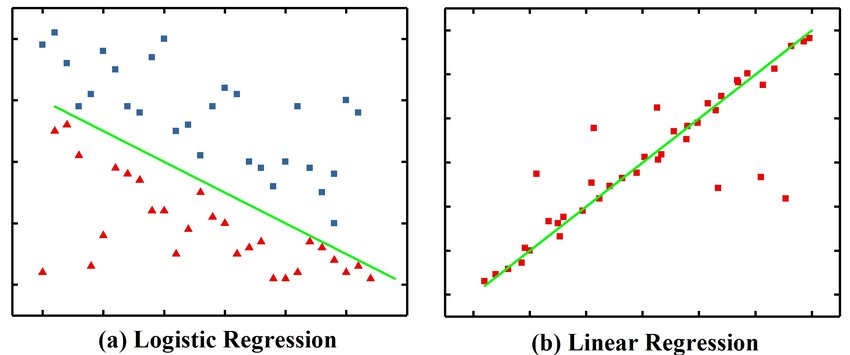

**SVM :-** 
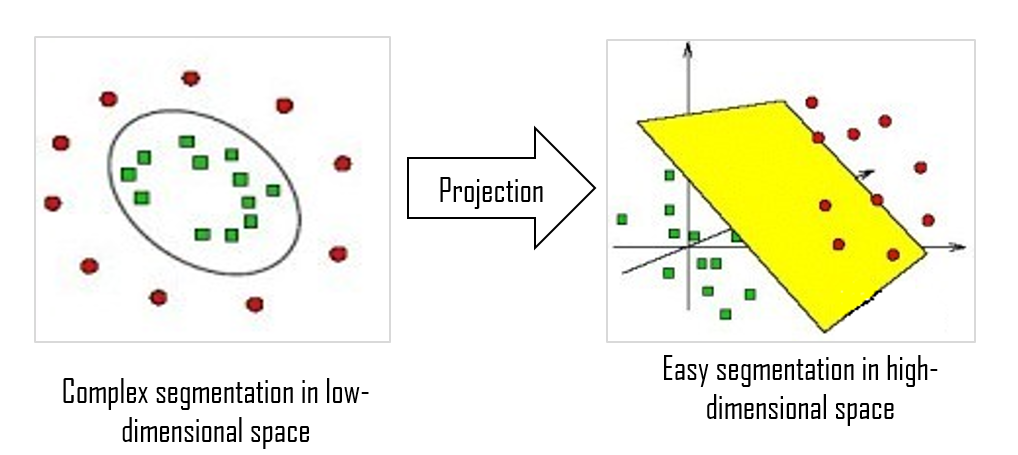

**Decision Trees :-**   
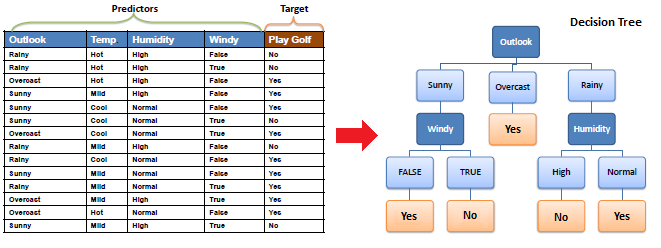


**Random Forest :-** 
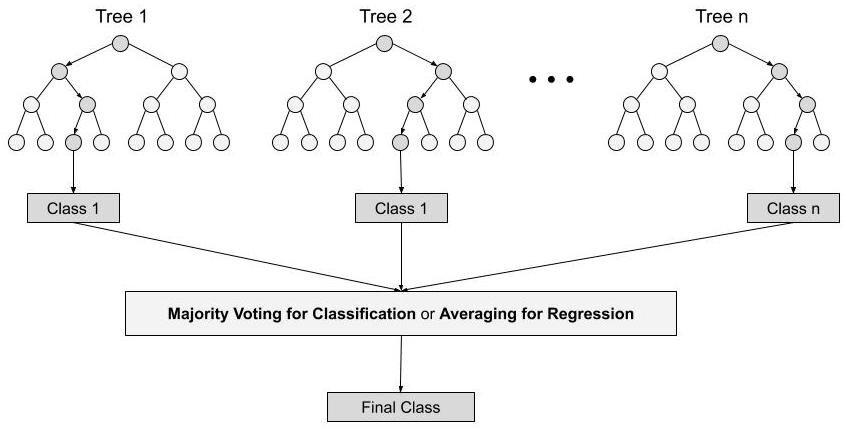

In [ ]:
# # In case of module on found error in the code, run the followings

# !pip install spacy==2.8
# !pip install seaborn
# !pip install numpy
# !pip install matplotlib
# !pip install pandas

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24


In [ ]:
# !python -m spacy download en_core_web_md

In [ ]:
import spacy
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_train = pd.read_csv('data/multidogo/train.tsv', delimiter='\t')
df_train = df_train.dropna(axis=0)
#  We'll be showing cross-validation in this notebook
# df_dev = pd.read_csv('data/multidogo/dev.tsv', delimiter='\t')
df_test = pd.read_csv('data/multidogo/test.tsv', delimiter='\t')
df_test = df_test.dropna(axis=0)

In [ ]:
df_train.head()

conversationId  turnNumber  sentenceNumber  \
0  15592755-d744-445f-a86e-552dc08e0aa5           0               0   
1  15592755-d744-445f-a86e-552dc08e0aa5           2               0   
2  15592755-d744-445f-a86e-552dc08e0aa5           4               0   
3  15592755-d744-445f-a86e-552dc08e0aa5           6               0   
4  15592755-d744-445f-a86e-552dc08e0aa5           7               0   

                                         utteranceId  \
0  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
1  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
2  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
3  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
4  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   

                                          utterance  \
0                                             hello   
1  i would like to purchase the internet connection   
2                                  washington 20001   
3                                        10 gb okab   
4                                        10 gb plan   

                               slot-labels              intent  
0                                        O     openinggreeting  
1               O O O O O O service_type O  startserviceintent  
2             current_city current_zipcode         contentonly  
3  datacategoryvalues datacategoryvalues O         contentonly  
4  datacategoryvalues datacategoryvalues O         contentonly

In [ ]:
df_test.head()

conversationId  turnNumber  sentenceNumber  \
0  76ba3fa6-466e-442e-ad61-10a82eb343ad           0               0   
1  76ba3fa6-466e-442e-ad61-10a82eb343ad           2               0   
2  76ba3fa6-466e-442e-ad61-10a82eb343ad           4               0   
3  76ba3fa6-466e-442e-ad61-10a82eb343ad           6               0   
4  0fc859b3-13a3-43ba-b2d0-17c8a8bb29c3           0               0   

                                         utteranceId              utterance  \
0  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...        i need internet   
1  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...  paramakiudi zip 25698   
2  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...                  10 gb   
3  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...            nothing too   
4  <CONV>0fc859b3-13a3-43ba-b2d0-17c8a8bb29c3<TUR...                  hello   

                             slot-labels              intent  
0                       O O service_type  startserviceintent  
1                    O O current_zipcode         contentonly  
2  datacategoryvalues datacategoryvalues         contentonly  
3                                    O O           rejection  
4                                      O     openinggreeting

In [ ]:
df_cleaner = df_train.groupby('intent').size().reset_index(name='counts')

df_cleaner

intent  counts
0                           cancelserviceintent       6
1                               closinggreeting     439
2                                  confirmation    1986
3                                   contentonly    3729
4                       getchannelpackageintent       2
5                          getinformationintent     199
6   getinformationintent<div>startserviceintent       1
7                               openinggreeting    1581
8                                   outofdomain     388
9                                     rejection    1497
10                           startserviceintent    1564
11  startserviceintent<div>upgradeserviceintent       1
12                                     thankyou     703
13                        transferserviceintent       8
14                            updateaccountinfo       1
15                         upgradeserviceintent      11
16                              viewbillsintent     116
17                          viewdatausageintent       2

In [ ]:
# now we balance our data by removing the intents with very low counts

intents_to_remove = []

for i, row in df_cleaner.iterrows():
    if row['counts'] < 100:
        intents_to_remove.append(row['intent'])    
print(intents_to_remove)

for i, row in df_train.iterrows():
    if row['intent'] in intents_to_remove:
        df_train.drop(i, inplace=True)
        
for i, row in df_test.iterrows():
    if row['intent'] in intents_to_remove:
        df_train.drop(i, inplace=True)

['cancelserviceintent', 'getchannelpackageintent', 'getinformationintent<div>startserviceintent', 'startserviceintent<div>upgradeserviceintent', 'transferserviceintent', 'updateaccountinfo', 'upgradeserviceintent', 'viewdatausageintent']


In [ ]:
df_train.groupby('intent').size().reset_index(name='counts')

intent  counts
0       closinggreeting     439
1          confirmation    1985
2           contentonly    3724
3  getinformationintent     199
4       openinggreeting    1581
5           outofdomain     388
6             rejection    1496
7    startserviceintent    1563
8              thankyou     703
9       viewbillsintent     116

In [ ]:
# convert your dataframe columns to lists containing user utterances and columns

sentences_train = df_train['utterance'].to_list()
labels_train = df_train['intent'].to_list()

sentences_test = df_test['utterance'].to_list()
labels_test = df_test['intent'].to_list()

In [ ]:
#convert labels into indices for the ML models

n_labels_train = len(labels_train)
print('Number of training labels :-', n_labels_train)
train_le = LabelEncoder()
train_y = train_le.fit_transform(labels_train)
print('Length of train y :- ',train_y.shape)
print('Number of classes:- ', len(train_le.classes_))
print('classes:- ', train_le.classes_)

print('------------------------------------------------------')

n_labels_test = len(labels_test)
print('Number of testing labels :-', n_labels_test)
test_le = LabelEncoder()
test_y = test_le.fit_transform(labels_train)
print('Length of test y :- ',test_y.shape)
print('Number of classes:- ', len(test_le.classes_))
# print('classes:- ', test_le.classes_)

Number of training labels :- 12194
Length of train y :-  (12194,)
Number of classes:-  10
classes:-  ['closinggreeting' 'confirmation' 'contentonly' 'getinformationintent'
 'openinggreeting' 'outofdomain' 'rejection' 'startserviceintent'
 'thankyou' 'viewbillsintent']
------------------------------------------------------
Number of testing labels :- 3489
Length of test y :-  (12194,)
Number of classes:-  10


Text(0.5, 1.0, 'class-wise count')

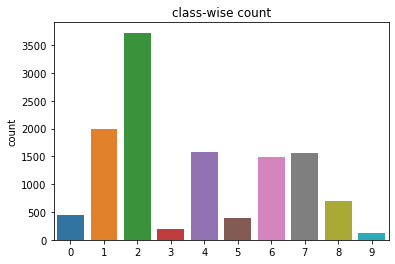

In [ ]:
sns.countplot(x=train_y).set_title("class-wise count")

In [ ]:
# download language model and the word embeddings

nlp = spacy.load('en_core_web_md')
embedding_dim = nlp.vocab.vectors_length

print(embedding_dim)

300


In [ ]:
# encode the training and test set to dense vectors using word embeddings

def encode_sentences(sentences):
    n_sentences = len(sentences)
    print('Length :-',n_sentences)

    X = np.zeros((n_sentences, embedding_dim))

    for idx, sentence in enumerate(sentences):
        doc = nlp(sentence)
        X[idx, :] = doc.vector
    return X

train_X = encode_sentences(sentences_train)
test_X = encode_sentences(sentences_test)

# # sample of the transformation
# print(train_X[0])
# print(sentences_train[0])

Length :- 12194
Length :- 3489


In [ ]:
# Import required libraries for machine learning classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Instantiate the machine learning classifiers
log_model = LogisticRegression(max_iter=10000)
svc_model = LinearSVC(dual=False)
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()

In [ ]:
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score, average='micro'),
           'recall':make_scorer(recall_score, average='micro'), 
           'f1_score':make_scorer(f1_score, average='micro')}

In [ ]:
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models performance metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

In [ ]:
models_evaluation(train_X, train_y, 5)

C:\Users\ratnesh\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  # nested dicts containing level 1: available loss functions,


Logistic Regression  Support Vector Classifier  Decision Tree  \
Accuracy                0.9289                   0.925702       0.884288   
Precision               0.9289                   0.925702       0.884288   
Recall                  0.9289                   0.925702       0.884288   
F1 Score                0.9289                   0.925702       0.884288   

           Random Forest  Gaussian Naive Bayes           Best Score  
Accuracy        0.922175              0.808678  Logistic Regression  
Precision       0.922175              0.808678  Logistic Regression  
Recall          0.922175              0.808678  Logistic Regression  
F1 Score        0.922175              0.808678  Logistic Regression

# Video Resources for Models used

**Logistic Regression :-** 
* https://www.youtube.com/watch?v=yIYKR4sgzI8

**SVM :-** 
* https://www.youtube.com/watch?v=efR1C6CvhmE&list=PLblh5JKOoLUL3IJ4-yor0HzkqDQ3JmJkc

**Decision Trees :-**   
* https://www.youtube.com/watch?v=7VeUPuFGJHk
* https://www.youtube.com/watch?v=_L39rN6gz7Y&t=11s

**Random Forest :-** 
* https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk

**Naive Bayes :-** 
* https://www.youtube.com/watch?v=O2L2Uv9pdDA
* https://www.youtube.com/watch?v=H3EjCKtlVog

# Slot Filling

**Slot filling** is the process of extracting relevant information from the user input.

In [ ]:
# !pip install tensorflow==1.14

     |████████████████████████████████| 109.3 MB 44 kB/s 
     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 488 kB 32.6 MB/s 
     |████████████████████████████████| 3.1 MB 34.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you

In [ ]:
import spacy
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [ ]:
# pretrained methed from spacy

LM = spacy.load("en_core_web_md")

In [ ]:
raw_text="The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."

text1= LM(raw_text)

for word in text1.ents: # only going over entities with 'text1.ents'
    print(word.text,word.label_)

The Indian Space Research Organisation ORG
the national space agency ORG
India GPE
Bengaluru GPE
Department of Space ORG
India GPE
ISRO ORG
DOS ORG


In [ ]:
spacy.displacy.render(text1,style="ent",jupyter=True)

- However these pretrained models aren't efficient with extracting information in the domain/task specific data due to entities now also including terms the model sees for the first time.

In [ ]:
raw_text2 = "i would like to purchase the internet connection in washington"
text2= LM(raw_text2)


spacy.displacy.render(text2,style="ent",jupyter=True)

print("Actual annotation: O O O O O O service_type O O current_city")

Actual annotation: O O O O O O service_type O O current_city


In [ ]:
# For training a entity extractor methods, we'll be using the same dataset as the one used in the Intent CLassification task

df_train = pd.read_csv('data/multidogo/train.tsv', delimiter='\t')
df_train = df_train.dropna(axis=0)
df_dev = pd.read_csv('data/multidogo/dev.tsv', delimiter='\t')
df_dev = df_dev.dropna(axis=0)
df_test = pd.read_csv('data/multidogo/test.tsv', delimiter='\t')
df_test = df_test.dropna(axis=0)

In [ ]:
df_train.head()

conversationId  turnNumber  sentenceNumber  \
0  15592755-d744-445f-a86e-552dc08e0aa5           0               0   
1  15592755-d744-445f-a86e-552dc08e0aa5           2               0   
2  15592755-d744-445f-a86e-552dc08e0aa5           4               0   
3  15592755-d744-445f-a86e-552dc08e0aa5           6               0   
4  15592755-d744-445f-a86e-552dc08e0aa5           7               0   

                                         utteranceId  \
0  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
1  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
2  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
3  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   
4  <CONV>15592755-d744-445f-a86e-552dc08e0aa5<TUR...   

                                          utterance  \
0                                             hello   
1  i would like to purchase the internet connection   
2                                  washington 20001   
3                                        10 gb okab   
4                                        10 gb plan   

                               slot-labels              intent  
0                                        O     openinggreeting  
1               O O O O O O service_type O  startserviceintent  
2             current_city current_zipcode         contentonly  
3  datacategoryvalues datacategoryvalues O         contentonly  
4  datacategoryvalues datacategoryvalues O         contentonly

In [ ]:
df_test.head()

conversationId  turnNumber  sentenceNumber  \
0  76ba3fa6-466e-442e-ad61-10a82eb343ad           0               0   
1  76ba3fa6-466e-442e-ad61-10a82eb343ad           2               0   
2  76ba3fa6-466e-442e-ad61-10a82eb343ad           4               0   
3  76ba3fa6-466e-442e-ad61-10a82eb343ad           6               0   
4  0fc859b3-13a3-43ba-b2d0-17c8a8bb29c3           0               0   

                                         utteranceId              utterance  \
0  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...        i need internet   
1  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...  paramakiudi zip 25698   
2  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...                  10 gb   
3  <CONV>76ba3fa6-466e-442e-ad61-10a82eb343ad<TUR...            nothing too   
4  <CONV>0fc859b3-13a3-43ba-b2d0-17c8a8bb29c3<TUR...                  hello   

                             slot-labels              intent  
0                       O O service_type  startserviceintent  
1                    O O current_zipcode         contentonly  
2  datacategoryvalues datacategoryvalues         contentonly  
3                                    O O           rejection  
4                                      O     openinggreeting

In [ ]:
def create_data(data_df):
    data_tokens = []
    data_tags = []
    for i, row in data_df.iterrows():
        tokens = []
        tags = []
        for x, y in zip(row['utterance'].split(" "), row['slot-labels'].split(" ")):
            tokens.append(x)
            tags.append(y)
        data_tokens.append(tokens)
        data_tags.append(tags)
    return data_tokens, data_tags


train_tokens, train_tags = create_data(df_train)
validation_tokens, validation_tags = create_data(df_dev)
test_tokens, test_tags = create_data(df_test)

In [ ]:
for i in range(2):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

hello	O

i	O
would	O
like	O
to	O
purchase	O
the	O
internet	service_type
connection	O



In [ ]:
# Prepare dictionaries
# {token} → {token id}: address the row in embeddings matrix for the current token;
# {tag} → {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

from collections import defaultdict

def build_dict(tokens_or_tags, special_tokens):

    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    k=0

    for line in special_tokens:
        tok2idx[line]=k
        k+=1
        idx2tok.append(line)
        
    for tokens in tokens_or_tags:
        for token in tokens:
            if token not in tok2idx: 
                tok2idx[token]=k 
                k += 1
                idx2tok.append(token)
    
    return tok2idx, idx2tok

In [ ]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [ ]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

In [ ]:
# Neural Networks are usually trained with batches.
# It means that weight updates of the network are based on several sequences at every single time.
# The tricky part is that all sequences within a batch need to have the same length.
# So we will pad them with a special <PAD> token.
# It is also a good practice to provide RNN with sequence lengths, so it can skip computations for padding parts.

def batches_generator(batch_size, tokens, tags,
                      shuffle=True, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    
    n_samples = len(tokens)
    if shuffle:
        order = np.random.permutation(n_samples)
    else:
        order = np.arange(n_samples)

    n_batches = n_samples // batch_size
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1

    for k in range(n_batches):
        batch_start = k * batch_size
        batch_end = min((k + 1) * batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        x_list = []
        y_list = []
        max_len_token = 0
        for idx in order[batch_start: batch_end]:
            x_list.append(words2idxs(tokens[idx]))
            y_list.append(tags2idxs(tags[idx]))
            max_len_token = max(max_len_token, len(tags[idx]))
            
        # Fill in the data into numpy nd-arrays filled with padding indices.
        x = np.ones([current_batch_size, max_len_token], dtype=np.int32) * token2idx['<PAD>']
        y = np.ones([current_batch_size, max_len_token], dtype=np.int32) * tag2idx['O']
        lengths = np.zeros(current_batch_size, dtype=np.int32)
        for n in range(current_batch_size):
            utt_len = len(x_list[n])
            x[n, :utt_len] = x_list[n]
            lengths[n] = utt_len
            y[n, :utt_len] = y_list[n]
        yield x, y, lengths

In [ ]:
import tensorflow as tf
import numpy as np

class BiLSTMModel():
    pass

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
def declare_placeholders(self):
    """Specifies placeholders for the model."""

    # Placeholders for input and ground truth output.
    self.input_batch = tf.placeholder(dtype=tf.int32, shape=[None, None], name='input_batch') 
    self.ground_truth_tags = tf.placeholder(dtype=tf.int32, shape=[None, None], name='ground_truth_tags')
  
    # Placeholder for lengths of the sequences.
    self.lengths = tf.placeholder(dtype=tf.int32, shape=[None], name='lengths') 
    
    # Placeholder for a dropout keep probability. If we don't feed
    # a value for this placeholder, it will be equal to 1.0.
    self.dropout_ph = tf.placeholder_with_default(tf.cast(1.0, tf.float32), shape=[])
    
    # Placeholder for a learning rate (tf.float32).
    self.learning_rate_ph = tf.placeholder(dtype=tf.float32,shape=[],name='learning_rate_ph')
    
BiLSTMModel.__declare_placeholders = classmethod(declare_placeholders)

In [ ]:
def build_layers(self, vocabulary_size, embedding_dim, n_hidden_rnn, n_tags):
    """Specifies bi-LSTM architecture and computes logits for inputs."""
    
    # Create embedding variable (tf.Variable) with dtype tf.float32
    initial_embedding_matrix = (np.random.randn(vocabulary_size, embedding_dim) / np.sqrt(embedding_dim))
    embedding_matrix_variable =tf.Variable(dtype=tf.float32,initial_value=initial_embedding_matrix,name='embeddings_matrix') 
    
    # Create RNN cells (for example, tf.nn.rnn_cell.BasicLSTMCell) with n_hidden_rnn number of units 
    # and dropout (tf.nn.rnn_cell.DropoutWrapper), initializing all *_keep_prob with dropout placeholder.
    forward_cell =  tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(num_units=n_hidden_rnn),input_keep_prob=self.dropout_ph, output_keep_prob=self.dropout_ph, state_keep_prob=self.dropout_ph)
    backward_cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.BasicLSTMCell(num_units=n_hidden_rnn),input_keep_prob=self.dropout_ph, output_keep_prob=self.dropout_ph, state_keep_prob=self.dropout_ph)

    # Look up embeddings for self.input_batch (tf.nn.embedding_lookup).
    # Shape: [batch_size, sequence_len, embedding_dim].
    embeddings = tf.nn.embedding_lookup(embedding_matrix_variable,self.input_batch)
    
    # Pass them through Bidirectional Dynamic RNN (tf.nn.bidirectional_dynamic_rnn).
    # Shape: [batch_size, sequence_len, 2 * n_hidden_rnn]. 
    # Also don't forget to initialize sequence_length as self.lengths and dtype as tf.float32.
    (rnn_output_fw, rnn_output_bw), _ = tf.nn.bidirectional_dynamic_rnn(forward_cell,backward_cell,inputs=embeddings,sequence_length=self.lengths,dtype=tf.float32)
    rnn_output = tf.concat([rnn_output_fw, rnn_output_bw], axis=2)

    # Dense layer on top.
    # Shape: [batch_size, sequence_len, n_tags].   
    self.logits = tf.layers.dense(rnn_output, n_tags, activation=None)
    
BiLSTMModel.__build_layers = classmethod(build_layers)

In [ ]:
def compute_predictions(self):
    """Transforms logits to probabilities and finds the most probable tags."""
    
    # Create softmax (tf.nn.softmax) function
    softmax_output = tf.nn.softmax(self.logits)
    
    # Use argmax (tf.argmax) to get the most probable tags
    # Don't forget to set axis=-1
    # otherwise argmax will be calculated in a wrong way
    self.predictions = tf.argmax(softmax_output,axis=-1)
    
BiLSTMModel.__compute_predictions = classmethod(compute_predictions)

In [ ]:
def compute_loss(self, n_tags, PAD_index):
    """Computes masked cross-entopy loss with logits."""
    
    # Create cross entropy function function (tf.nn.softmax_cross_entropy_with_logits)
    ground_truth_tags_one_hot = tf.one_hot(self.ground_truth_tags, n_tags)
    loss_tensor = tf.nn.softmax_cross_entropy_with_logits(labels=ground_truth_tags_one_hot,logits=self.logits)
    
    mask = tf.cast(tf.not_equal(loss_tensor, PAD_index), tf.float32)
    # Create loss function which doesn't operate with <PAD> tokens (tf.reduce_mean)
    # Be careful that the argument of tf.reduce_mean should be
    # multiplication of mask and loss_tensor.
    self.loss = tf.reduce_mean(tf.multiply(loss_tensor,mask))
    
BiLSTMModel.__compute_loss = classmethod(compute_loss)

In [ ]:
def perform_optimization(self):
    """Specifies the optimizer and train_op for the model."""
    
    # Create an optimizer (tf.train.AdamOptimizer)
    self.optimizer =  tf.train.AdamOptimizer(self.learning_rate_ph)
    self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
    
    # Gradient clipping (tf.clip_by_norm) for self.grads_and_vars
    # Pay attention that you need to apply this operation only for gradients 
    # because self.grads_and_vars contains also variables.
    # list comprehension might be useful in this case.
    clip_norm = tf.cast(1.0, tf.float32)
    self.grads_and_vars =  [(None, var) if grad is None else (tf.clip_by_norm(grad, clip_norm), var) for grad, var in self.grads_and_vars]    
    self.train_op = self.optimizer.apply_gradients(self.grads_and_vars)
    
BiLSTMModel.__perform_optimization = classmethod(perform_optimization)

In [ ]:
def init_model(self, vocabulary_size, n_tags, embedding_dim, n_hidden_rnn, PAD_index):
    self.__declare_placeholders()
    self.__build_layers(vocabulary_size, embedding_dim, n_hidden_rnn, n_tags)
    self.__compute_predictions()
    self.__compute_loss(n_tags, PAD_index)
    self.__perform_optimization()
    
BiLSTMModel.__init__ = classmethod(init_model)

In [ ]:
def train_on_batch(self, session, x_batch, y_batch, lengths, learning_rate, dropout_keep_probability):
    feed_dict = {self.input_batch: x_batch,
                 self.ground_truth_tags: y_batch,
                 self.learning_rate_ph: learning_rate,
                 self.dropout_ph: dropout_keep_probability,
                 self.lengths: lengths}
    
    session.run(self.train_op, feed_dict=feed_dict)
    
BiLSTMModel.train_on_batch = classmethod(train_on_batch)

In [ ]:
def predict_for_batch(self, session, x_batch, lengths):
    feed_dict={self.input_batch:x_batch,self.lengths:lengths}
    predictions=session.run(self.predictions,feed_dict=feed_dict)
    return predictions

BiLSTMModel.predict_for_batch = classmethod(predict_for_batch)

In [ ]:
from evaluation import precision_recall_f1


In [ ]:
def predict_tags(model, session, token_idxs_batch, lengths):
    """Performs predictions and transforms indices to tokens and tags."""
    
    tag_idxs_batch = model.predict_for_batch(session, token_idxs_batch, lengths)
    
    tags_batch, tokens_batch = [], []
    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
        tags, tokens = [], []
        for tag_idx, token_idx in zip(tag_idxs, token_idxs):
            tags.append(idx2tag[tag_idx])
            tokens.append(idx2token[token_idx])
        tags_batch.append(tags)
        tokens_batch.append(tokens)
        
    return tags_batch, tokens_batch

In [ ]:
def eval_conll(model, session, tokens, tags, short_report=True):
    """Computes NER quality measures using CONLL shared task script."""
    
    y_true, y_pred = [], []
    for x_batch, y_batch, lengths in batches_generator(1, tokens, tags):
        tags_batch, tokens_batch = predict_tags(model, session, x_batch, lengths)
        if len(x_batch[0]) != len(tags_batch[0]):
            raise Exception("Incorrect length of prediction for the input, "
                            "expected length: %i, got: %i" % (len(x_batch[0]), len(tags_batch[0])))
        predicted_tags = []
        ground_truth_tags = []
        for gt_tag_idx, pred_tag, token in zip(y_batch[0], tags_batch[0], tokens_batch[0]): 
            if token != '<PAD>':
                ground_truth_tags.append(idx2tag[gt_tag_idx])
                predicted_tags.append(pred_tag)

        # We extend every prediction and ground truth sequence with 'O' tag
        # to indicate a possible end of entity.
        y_true.extend(ground_truth_tags + ['O'])
        y_pred.extend(predicted_tags + ['O'])
        
    results = precision_recall_f1(y_true, y_pred, print_results=True, short_report=short_report)
    return results

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()


model = BiLSTMModel(len(idx2token),len(idx2tag),200,200,token2idx['<PAD>'])

batch_size = 32
n_epochs = 5
learning_rate = 0.007
learning_rate_decay = np.sqrt(2)
dropout_keep_probability = 0.5

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
%%time

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print('Start training... \n')
for epoch in range(n_epochs):
    # For each epoch evaluate the model on train and validation data
    print('-' * 20 + ' Epoch {} '.format(epoch+1) + 'of {} '.format(n_epochs) + '-' * 20)
    print('Train data evaluation:')
    eval_conll(model, sess, train_tokens, train_tags, short_report=True)
    print('Validation data evaluation:')
    eval_conll(model, sess, validation_tokens, validation_tags, short_report=True)
    
    # Train the model
    for x_batch, y_batch, lengths in batches_generator(batch_size, train_tokens, train_tags):
        model.train_on_batch(sess, x_batch, y_batch, lengths, learning_rate, dropout_keep_probability)
        
    # Decaying the learning rate
    learning_rate = learning_rate / learning_rate_decay
    
print('...training finished.')

Start training... 

-------------------- Epoch 1 of 5 --------------------
Train data evaluation:
processed 105778 tokens with 4489 phrases; found: 74694 phrases; correct: 174.

precision:  0.23%; recall:  3.88%; F1:  0.44

Validation data evaluation:
processed 12836 tokens with 537 phrases; found: 9090 phrases; correct: 27.

precision:  0.30%; recall:  5.03%; F1:  0.56

-------------------- Epoch 2 of 5 --------------------
Train data evaluation:
processed 105778 tokens with 4489 phrases; found: 2023 phrases; correct: 727.

precision:  35.94%; recall:  16.20%; F1:  22.33

Validation data evaluation:
processed 12836 tokens with 537 phrases; found: 183 phrases; correct: 73.

precision:  39.89%; recall:  13.59%; F1:  20.28

-------------------- Epoch 3 of 5 --------------------
Train data evaluation:
processed 105778 tokens with 4489 phrases; found: 4321 phrases; correct: 2601.

precision:  60.19%; recall:  57.94%; F1:  59.05

Validation data evaluation:
processed 12836 tokens with 537 p

In [ ]:
print('-' * 20 + ' Train set quality: ' + '-' * 20)
train_results = eval_conll(model, sess, train_tokens, train_tags, short_report=False)

print('-' * 20 + ' Validation set quality: ' + '-' * 20)
validation_results =eval_conll(model, sess, validation_tokens, validation_tags, short_report=False)

print('-' * 20 + ' Test set quality: ' + '-' * 20)
test_results = eval_conll(model, sess, test_tokens, test_tags, short_report=False)

-------------------- Train set quality: --------------------
processed 105778 tokens with 4489 phrases; found: 4630 phrases; correct: 4149.

precision:  89.61%; recall:  92.43%; F1:  91.00

	     company: precision:   93.26%; recall:   94.71%; F1:   93.98; predicted:   653

	    facility: precision:   84.50%; recall:   88.54%; F1:   86.47; predicted:   329

	     geo-loc: precision:   94.64%; recall:   97.59%; F1:   96.09; predicted:  1027

	       movie: precision:   58.02%; recall:   69.12%; F1:   63.09; predicted:    81

	 musicartist: precision:   77.69%; recall:   84.05%; F1:   80.75; predicted:   251

	       other: precision:   87.98%; recall:   92.87%; F1:   90.36; predicted:   799

	      person: precision:   94.00%; recall:   97.18%; F1:   95.56; predicted:   916

	     product: precision:   86.77%; recall:   88.68%; F1:   87.71; predicted:   325

	  sportsteam: precision:   86.67%; recall:   83.87%; F1:   85.25; predicted:   210

	      tvshow: precision:   51.28%; recall:  

# Sentence Clustering using hdbscan

**DATA :-** https://github.com/PolyAI-LDN/task-specific-datasets/tree/master/banking_data

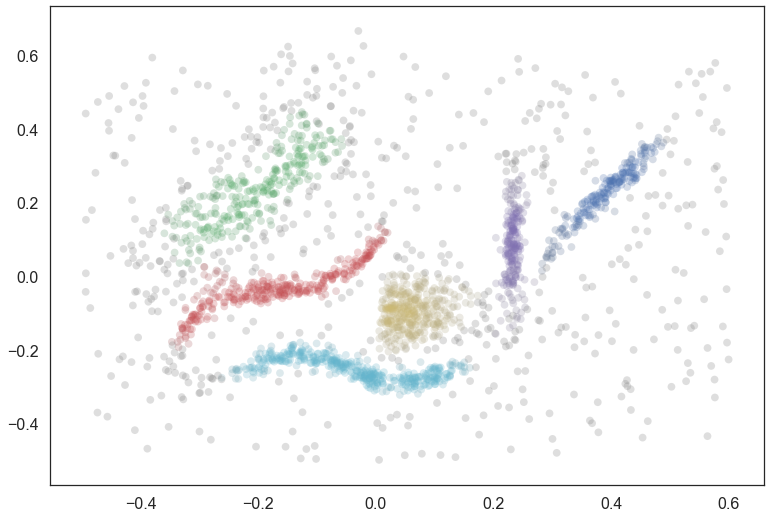

In [ ]:
# !pip install tensorflow tensorflow_hub
# !pip install -U sentence-transformers
# !pip install umap-learn
# !pip install hdbscan

     |████████████████████████████████| 462 kB 5.4 MB/s 
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 30.6 MB/s 
     |████████████████████████████████| 1.2 MB 42.6 MB/s 
     |████████████████████████████████| 77 kB 2.5 MB/s 
     |████████████████████████████████| 6.6 MB 36.1 MB/s 
     |████████████████████████████████| 895 kB 46.7 MB/s 
     |████████████████████████████████| 596 kB 47.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b75c11a5949756f8d3c8c7cccef960df4a848abf3e7246b4dceafc100e5c3b16
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |█

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

import pandas as pd
import random
import umap.umap_ as umap
import hdbscan
import numpy as np

In [ ]:
df = pd.read_csv('data/banking77/train.csv')

df.head()

text      category
0                     I am still waiting on my card?  card_arrival
1  What can I do if my card still hasn't arrived ...  card_arrival
2  I have been waiting over a week. Is the card s...  card_arrival
3  Can I track my card while it is in the process...  card_arrival
4  How do I know if I will get my card, or if it ...  card_arrival

In [ ]:
data_sample = df.sample(1000, random_state=42)

data_sample.head()

text  \
6883     Is it possible for me to change my PIN number?   
5836               I'm not sure why my card didn't work   
8601                     I don't think my top up worked   
2545  Can you explain why my payment was charged a fee?   
8697  How long does a transfer from a UK account tak...   

                                     category  
6883                               change_pin  
5836                    declined_card_payment  
8601                            top_up_failed  
2545                 card_payment_fee_charged  
8697  balance_not_updated_after_bank_transfer

In [ ]:
all_intents = list(data_sample['text'])

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('paraphrase-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def embed(model, model_type, sentences):
    """
    wrapper function for generating message embeddings
    """
  
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    
    return embeddings

In [ ]:
embeddings_use = embed(model_use, 'use', all_intents)
embeddings_st1 = embed(model_st1, 'sentence transformer', all_intents)
embeddings_st2 = embed(model_st2, 'sentence transformer', all_intents)
embeddings_st3 = embed(model_st3, 'sentence transformer', all_intents)

In [ ]:
print(embeddings_use.shape)
print(embeddings_st1.shape)
print(embeddings_st2.shape)
print(embeddings_st3.shape)

(1000, 512)
(1000, 768)
(1000, 384)
(1000, 768)


In [ ]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      random_state = None):
    """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors, 
                                n_components=n_components, 
                                metric='cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [ ]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given cluster supplied from running hdbscan
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [ ]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search hyperparameter space and limited number of times 
    and return a summary of the results
    """
    
    results = []
    
    for i in range(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors = n_neighbors, 
                                     n_components = n_components, 
                                     min_cluster_size = min_cluster_size, 
                                     random_state = 42)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, 
                        label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [ ]:
space = {"n_neighbors": range(12, 16),
        "n_components": range(3, 7),
        "min_cluster_size": range(2, 16),
        "random_state": 42
}

random_use = random_search(embeddings_use, space, 100)

In [ ]:
random_use[0:50]

run_id  n_neighbors  n_components  min_cluster_size  label_count   cost
19      19           12             4                15            6  0.015
79      79           12             4                14            6  0.016
39      39           13             3                14            6  0.018
87      87           12             3                13            7  0.020
76      76           12             6                14            6  0.028
57      57           13             4                 2          120  0.121
80      80           14             3                 3           79  0.124
8        8           13             6                 2          123  0.124
60      60           14             3                 4           66  0.129
52      52           14             5                 2          117  0.132
64      64           14             5                 2          117  0.132
95      95           15             6                 3           82  0.135
31      31           12             3                 3           82  0.140
22      22           15             5                 2          122  0.142
56      56           15             5                 2          122  0.142
10      10           12             5                 3           89  0.144
30      30           15             4                 2          106  0.145
43      43           15             3                 3           80  0.147
70      70           12             6                 2          120  0.148
50      50           12             6                 2          120  0.148
16      16           13             5                 3           85  0.149
47      47           14             6                 4           64  0.150
84      84           14             6                 4           64  0.150
90      90           12             6                 3           80  0.150
23      23           15             3                 2          125  0.154
44      44           13             4                 4           66  0.156
1        1           14             6                 3           82  0.157
40      40           13             3                 6           48  0.159
96      96           12             4                 5           61  0.160
73      73           14             3                 2          128  0.163
59      59           12             3                 4           71  0.165
82      82           14             4                 4           66  0.167
75      75           14             4                 4           66  0.167
36      36           13             4                 6           49  0.174
33      33           13             3                 5           61  0.177
48      48           13             4                 7           47  0.178
65      65           13             4                 7           47  0.178
98      98           13             6                 7           47  0.183
86      86           14             6                 6           48  0.184
97      97           14             4                 5           57  0.184
28      28           12             5                 4           73  0.184
45      45           15             3                 5           57  0.185
0        0           12             5                 6           51  0.186
49      49           12             6                 8           36  0.186
9        9           15             6                 7           43  0.189
5        5           12             3                 8           39  0.191
13      13           13             5                 7           46  0.192
62      62           13             5                 7           46  0.192
63      63           12             4                 6           54  0.199
68      68           14             5                 8           34  0.200

In [ ]:
df_cleaner = data_sample.groupby('category').size().reset_index(name='counts')

df_cleaner

category  counts
0                     Refund_not_showing_up      12
1                          activate_my_card      19
2                                 age_limit      13
3                   apple_pay_or_google_pay      11
4                               atm_support      12
..                                      ...     ...
72                 virtual_card_not_working       6
73                       visa_or_mastercard      15
74                      why_verify_identity       8
75            wrong_amount_of_cash_received      20
76  wrong_exchange_rate_for_cash_withdrawal      17

[77 rows x 2 columns]

KeyError: ignored